In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.sparse.csgraph import reverse_cuthill_mckee

from matplotlib import pyplot as plt

In [2]:
class Mesh:
    def __init__(self):
        self.nodes_dict = {}   # Nodes dict <---> ID: [x y z]
        self.elems_dict = {}   # Elems dict <---> ID: [ne_1, ne_2, ...]
        self.N_nodes = 0
        self.N_elems = 0
        
    def read_mesh(self, mesh_name):
        # Reading nodes
        nodes_file = open(mesh_name + '_nodes.txt', 'r')
        
        for line in nodes_file:
            data_tokens = list(map(float, line.split(' ')))
            node_ID = int(data_tokens[0])
            coord_array = data_tokens[1:]
            self.nodes_dict[node_ID] = coord_array
            
        self.N_nodes = len(self.nodes_dict.keys())
        nodes_file.close()
        
        # Reading elems
        elems_file = open(mesh_name + '_elems.txt', 'r')
        
        for line in elems_file:
            if (line == ''):
                break
            data_tokens = list(map(int, line.replace(' \n', '').split(' ')))
            elem_ID = data_tokens[0]
            elem_nodes = data_tokens[1:]
            self.elems_dict[elem_ID] = elem_nodes
            
        self.N_elems = len(self.elems_dict.keys())
        elems_file.close()
        
        print(f'Mesh from [{mesh_name}] loaded.\n')
        print(f'Nodes: \t\t{self.N_nodes}')
        print(f'Elements: \t{self.N_elems}')
    
    def get_mesh(self):
        return self.nodes_dict, self.elems_dict

In [3]:
class FEM:
    def __init__(self, nodes_dict, elems_dict, nu, E):
        self.nodes_dict = nodes_dict                    # Nodes dict <---> ID: [x y z]
        self.elems_dict = elems_dict                    # Elems dict <---> ID: [ne_1, ne_2, ...]
        
        self.N_nodes = len(nodes_dict.keys())
        self.N_elems = len(elems_dict.keys())
        
        self.N_dofs = self.N_nodes * 2                  # 2D case, DOFs along X and Y
        self.dofs_mapping = {}                          # Degrees of freedom for each element
        
        self.nu = nu
        self.E = E
        
        self.local_K = np.ones((6,6))                  
        self.global_K = None                            # Global stiffness matrix K
        
        self.D = E * np.array([
            [1-nu, nu, 0],
            [nu, 1-nu, 0],
            [0, 0, 0.5*(1-2*nu)]
        ]) / ((1 + nu)*(1 - 2*nu))                      # Hook's Law in matrix law
        
        self.F = np.zeros(self.N_dofs)                  # Nodal forces
        self.U = np.zeros(self.N_dofs)                  # Displacements
        self.fixed_dofs = []                            # Fixed nodes
        self.all_dofs = np.arange(self.N_dofs)
        
    # For each element, calculates its nodes DOFs    
    def map_dofs(self):
        for elem in list(self.elems_dict.keys()):
            nodes = self.elems_dict[elem]
            dofs = []
            for node in nodes:
                dofs.append(2*(node-1))       # DOF along X
                dofs.append(2*(node-1) + 1)   # DOF along Y
            self.dofs_mapping[elem] = dofs
    
    # For triangular mesh?
    def assemble_stiffness_matrix(self):
        global_iK = np.zeros(36 * self.N_elems)
        global_jK = np.zeros(36 * self.N_elems)
        global_aK = np.zeros(36 * self.N_elems)
        
        for ei, elem in enumerate(list(self.elems_dict.keys())):
            iK = np.kron(self.dofs_mapping[elem], np.ones(6))
            jK = np.reshape(np.kron(self.dofs_mapping[elem], np.reshape(np.ones(6), (6,1))), -1)
            aK = np.reshape(self.local_stiffness_matrix(elem), -1)
            
            global_iK[36*ei : 36*(ei+1)] = iK
            global_jK[36*ei : 36*(ei+1)] = jK
            global_aK[36*ei : 36*(ei+1)] = aK
            
        self.global_K = sparse.coo_matrix((global_aK,(global_iK, global_jK)),shape = (self.N_dofs, self.N_dofs)).tocsr()
        
    def local_stiffness_matrix(self, elem_ID):
        elem_nodes_IDs = self.elems_dict[elem_ID]
        elem_nodes_coords = [self.nodes_dict[node_id] for node_id in elem_nodes_IDs]
        
        x1 = elem_nodes_coords[0][0]
        x2 = elem_nodes_coords[1][0]
        x3 = elem_nodes_coords[2][0]
        
        y1 = elem_nodes_coords[0][1]
        y2 = elem_nodes_coords[1][1]
        y3 = elem_nodes_coords[2][1]
        
        jacobian = np.array([
            [x2 - x1, x3 - x1],
            [y2 - y1, y3 - y1]
        ])
        
        inv_jacobian = np.linalg.inv(jacobian)
        xi_x = inv_jacobian[0][0]
        xi_y = inv_jacobian[0][1]
        eta_x = inv_jacobian[1][0]
        eta_y = inv_jacobian[1][1]
        
        B = np.array([
            [-xi_x - xi_y, 0, xi_x, 0, xi_y, 0],
            [0, -eta_x - eta_y, 0, eta_x, 0, eta_y],
            [-eta_x - eta_y, -xi_x - xi_y, eta_x, xi_x, eta_y, xi_y]
        ])
        
        local_stiffness_matrix = 0.5 * np.linalg.det(jacobian) * np.dot(np.transpose(B), np.dot(self.D, B))
        
        return local_stiffness_matrix
    
    def solve_U(self):
        free_dofs = np.setdiff1d(self.all_dofs, self.fixed_dofs)
        self.U[free_dofs] = spsolve(self.global_K[free_dofs, :][:, free_dofs], self.F[free_dofs])
        
        return self.U
        
    def apply_load(self, node_ID, force_X, force_Y):
        dof_x = 2*(node_ID-1)
        dof_y = 2*(node_ID-1) + 1
        self.F[dof_x] = force_X
        self.F[dof_y] = force_Y
        
    def fix_node(self, node_ID, fix_X, fix_Y):
        dof_x = 2*(node_ID-1)
        dof_y = 2*(node_ID-1) + 1
        if (fix_X == True):
            self.fixed_dofs.append(dof_x)
        if (fix_Y == True):
            self.fixed_dofs.append(dof_y)
        
    def build_incidence_matrix(self):
        self.incidence_matrix = np.zeros((self.N_nodes, self.N_nodes))
        
        # Calculating incidence from elements
        for elem_ID in list(self.elems_dict.keys()):
            nodes = self.elems_dict[elem_ID]
            for i in range(len(nodes)):
                self.incidence_matrix[nodes[i]-1][nodes[i-1]-1] = 1                # Marking LEFT neighbor
                self.incidence_matrix[nodes[i]-1][nodes[(i+1)%len(nodes)]-1] = 1   # Marking RIGHT neighbor
                self.incidence_matrix[nodes[i]-1][nodes[i]-1] = 1                  # Marking node itself
                
    def renumbering(self):
        graph = sparse.csr_matrix(self.incidence_matrix)                     # Creating input graph in scipy sparse matrix form
        permutation = reverse_cuthill_mckee(graph, symmetric_mode = True)    # Incidence matrix is guaranteed to be symmetric
        
        # Updating incidence matrix
        self.incidence_matrix = self.incidence_matrix[permutation, :][:, permutation]
        self.renum_perm = permutation
        
    def revert_renumbering(self):
        inverse_perm = np.argsort(self.renum_perm)
        
        self.incidence_matrix = self.incidence_matrix[inverse_perm, :][:, inverse_perm]
                
    def draw_incidence_matrix(self):
        plt.figure(figsize=(9, 9))
        plt.imshow(self.incidence_matrix, cmap = 'turbo', interpolation = 'gaussian')
        
    def draw_stiffness_matrix(self):
        if (self.N_dofs > 3000):
            print("Too much DOFs: cannot visualize stiffness matrix")
            return
        
        plt.figure(figsize=(7, 7))
        np_represent = self.global_K.toarray()
        for i in range(np_represent.shape[0]):
            for j in range(np_represent.shape[0]):
                if (np_represent[i][j] != 0):
                    np_represent[i][j] = 1.0
                    
        plt.imshow(np_represent, cmap = 'hot')

In [4]:
mesh = Mesh()
mesh.read_mesh('Mesh_1')

mesh_nodes, mesh_elems = mesh.get_mesh()

Mesh from [Mesh_1] loaded.

Nodes: 		934
Elements: 	1728


In [5]:
f_matr = FEM(mesh_nodes, mesh_elems, 0.3, 1e9)
f_matr.build_incidence_matrix()

In [6]:
f_matr.map_dofs()

In [7]:
f_matr.assemble_stiffness_matrix()

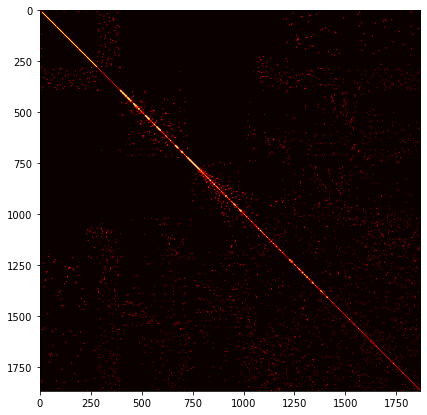

In [8]:
f_matr.draw_stiffness_matrix()

In [9]:
f_matr.fix_node(1, True, True)
f_matr.fix_node(100, True, True)
f_matr.apply_load(200, 0, -1)

In [10]:
# Getting displacements
U = f_matr.solve_U()